# Assignment: Training EEGNet on P300 EEG Data

In this assignment, you will work with real EEG data from a P300 speller experiment and implement the EEGNet architecture to detect P300 responses. The emphasis of this assignment is on understanding and implementing the EEGNet model rather than extensive signal preprocessing.

**Instructions:**
- Complete the provided code scaffolding
- Fill in missing logic where indicated
- Focus especially on the EEGNet architecture and training


## Part 1: Loading and Inspecting the Dataset

In this section, you will load the EEG dataset and inspect its basic structure. The dataset contains continuous EEG recordings along with stimulus and label information.

In [ ]:
import scipy.io as sio
import numpy as np

# Load the dataset
# TODO: Update the path if needed
data = sio.loadmat('Subject_A_Train.mat')


print(data.keys())


dict_keys(['__header__', '__version__', '__globals__', 'Signal', 'TargetChar', 'Flashing', 'StimulusCode', 'StimulusType'])


## Part 2: Understanding the Experimental Design

The P300 speller paradigm is based on detecting brain responses to rare target stimuli. In this section, you will identify how stimulus timing and labels are encoded in the data.

In [ ]:


if 'data' in locals():
    # 1. Continuous EEG signal

    raw_eeg = data['Signal']

    # 2. Stimulus onset information
    flashing = data['Flashing']

    # 3. Target vs non-target labels
    stimulus_type = data['StimulusType']


    fs = 240.0

    print(f"EEG Shape: {raw_eeg.shape}")
    print(f"Flashing Shape: {flashing.shape}")
    print(f"Stimulus Type Shape: {stimulus_type.shape}")

EEG Shape: (85, 7794, 64)
Flashing Shape: (85, 7794)
Stimulus Type Shape: (85, 7794)


## Part 3: EEG Epoch Extraction

EEGNet does not operate on continuous EEG. Instead, the signal must be segmented into short epochs following each stimulus. This step converts raw EEG into trials suitable for supervised learning.

In [ ]:
import numpy as np
def extract_epochs(signal, flashing, stimulus_type, fs, t_start=0.0, t_end=0.8):
    """
    Extract epochs from 3D BCI Competition data (Trials x Time x Channels).
    """

    t_min_samples = int(t_start * fs)
    t_max_samples = int(t_end * fs)

    epochs = []
    labels = []


    if signal.ndim == 3:
        num_runs = signal.shape[0]
        print(f"Processing {num_runs} runs...")

        for run_idx in range(num_runs):

            run_signal = signal[run_idx, :, :]
            run_flashing = flashing[run_idx, :]
            run_stim_type = stimulus_type[run_idx, :]


            diff = np.diff(run_flashing, prepend=0)
            starts = np.where(diff == 1)[0]

            for start_idx in starts:
                end_idx = start_idx + t_max_samples

                if end_idx < run_signal.shape[0]:

                    epoch = run_signal[start_idx + t_min_samples : end_idx, :]


                    epoch = epoch.T

                    epochs.append(epoch)
                    labels.append(run_stim_type[start_idx])

    elif signal.ndim == 2:

        diff = np.diff(flashing.flatten(), prepend=0)
        starts = np.where(diff == 1)[0]
        for start_idx in starts:
            if start_idx + t_max_samples < signal.shape[0]:
                epoch = signal[start_idx + t_min_samples : start_idx + t_max_samples, :].T
                epochs.append(epoch)
                labels.append(stimulus_type.flatten()[start_idx])

    return np.array(epochs), np.array(labels)


if 'data' in locals():
    X, Y = extract_epochs(raw_eeg, flashing, stimulus_type, fs)
    print(f"Extracted X Shape: {X.shape}")
    print(f"Extracted Y Shape: {Y.shape}")

Processing 85 runs...
Extracted X Shape: (15300, 64, 192)
Extracted Y Shape: (15300,)


## Part 4: Preparing Data for EEGNet

In this section, you will perform minimal preprocessing to make the data compatible with EEGNet. Extensive signal processing is not required.

In [ ]:
def prepare_for_eegnet(epochs):
    """
    Prepare EEG epochs for input into EEGNet.

    Input: (Trials, Channels, Time)
    Output: (Trials, Channels, Time, 1) -- Standard Image Format
    """

    return np.expand_dims(epochs, axis=-1)


if 'X' in locals():
    X_prepared = prepare_for_eegnet(X)
    print(f"Prepared Data Shape (Channels Last): {X_prepared.shape}")

Prepared Data Shape (Channels Last): (15300, 64, 192, 1)


## Part 5: Implementing EEGNet

This is the core part of the assignment. You will implement the EEGNet architecture as discussed in class. Focus on matching the block structure and understanding the role of each layer.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D,
                                     SeparableConv2D, BatchNormalization,
                                     AveragePooling2D, Dropout, Flatten, Dense, Activation)
from tensorflow.keras.constraints import max_norm

def EEGNet(nb_classes, Chans, Samples, F1=8, D=2, F2=16, dropoutRate=0.5):
    """
    EEGNet architecture (Channels Last Version).
    """

    # 1. Input Shape Change: (Chans, Samples, 1)
    input1 = Input(shape=(Chans, Samples, 1))


    block1 = Conv2D(F1, (1, 64), padding='same',
                    input_shape=(Chans, Samples, 1),
                    use_bias=False)(input1)


    block1 = BatchNormalization(axis=-1)(block1)


    # Block 1: Spatial Convolution (Depthwise)


    block1 = DepthwiseConv2D((Chans, 1), use_bias=False,
                             depth_multiplier=D,
                             depthwise_constraint=max_norm(1.))(block1)

    block1 = BatchNormalization(axis=-1)(block1)
    block1 = Activation('elu')(block1)


    block1 = AveragePooling2D((1, 4))(block1)
    block1 = Dropout(dropoutRate)(block1)


    # Block 2: Separable Convolution

    block2 = SeparableConv2D(F2, (1, 16), use_bias=False,
                             padding='same')(block1)

    block2 = BatchNormalization(axis=-1)(block2)
    block2 = Activation('elu')(block2)

    # Pooling
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = Dropout(dropoutRate)(block2)


    # Classification

    flatten = Flatten(name='flatten')(block2)

    # Keep kernel_constraint (Keras 3 fix)
    dense = Dense(nb_classes, name='dense', kernel_constraint=max_norm(0.25))(flatten)
    softmax = Activation('softmax', name='softmax')(dense)

    return Model(inputs=input1, outputs=softmax)


if 'X_prepared' in locals():
    # Check shape (N, C, T, 1)
    if X_prepared.shape[-1] == 1:
        trials, chans, samples, kernels = X_prepared.shape
        print(f"Building Model (Channels Last): Chans={chans}, Samples={samples}")

        model = EEGNet(nb_classes=2, Chans=chans, Samples=samples)
        model.summary()
    else:
        print("Error: X_prepared shape is wrong. Please run the NEW Part 4 code above.")

Building Model (Channels Last): Chans=64, Samples=192


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 192, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 192, 8)     │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 192, 8)     │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 1, 192, 16)     │         1,024 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1, 192, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 1, 192, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 1, 48, 16)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 48, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 1, 48, 16)      │           512 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1, 48, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1, 48, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 1, 6, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           194 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,402 (9.38 KB)

 Trainable params: 2,322 (9.07 KB)

 Non-trainable params: 80 (320.00 B)

## Part 6: Training the Model

In this section, you will train EEGNet to distinguish between P300 and non-P300 EEG epochs.

Training Shape: (12240, 64, 192, 1)
Starting training...
Epoch 1/20
765/765 ━━━━━━━━━━━━━━━━━━━━ 207s 268ms/step - accuracy: 0.5472 - loss: 0.6891 - val_accuracy: 0.6271 - val_loss: 0.6505
Epoch 2/20
765/765 ━━━━━━━━━━━━━━━━━━━━ 205s 267ms/step - accuracy: 0.6397 - loss: 0.6254 - val_accuracy: 0.6781 - val_loss: 0.6169
Epoch 3/20
765/765 ━━━━━━━━━━━━━━━━━━━━ 197s 258ms/step - accuracy: 0.6637 - loss: 0.6171 - val_accuracy: 0.6676 - val_loss: 0.6212
Epoch 4/20
765/765 ━━━━━━━━━━━━━━━━━━━━ 213s 272ms/step - accuracy: 0.6685 - loss: 0.6091 - val_accuracy: 0.7059 - val_loss: 0.5845
Epoch 5/20
765/765 ━━━━━━━━━━━━━━━━━━━━ 205s 268ms/step - accuracy: 0.7008 - loss: 0.5984 - val_accuracy: 0.6886 - val_loss: 0.5906
Epoch 6/20
765/765 ━━━━━━━━━━━━━━━━━━━━ 205s 268ms/step - accuracy: 0.6955 - loss: 0.5887 - val_accuracy: 0.7242 - val_loss: 0.5692
Epoch 7/20
765/765 ━━━━━━━━━━━━━━━━━━━━ 205s 267ms/step - accuracy: 0.7003 - loss: 0.5885 - val_accuracy: 0.7484 - val_loss: 0.5559
Epoch 8/20
765/765 

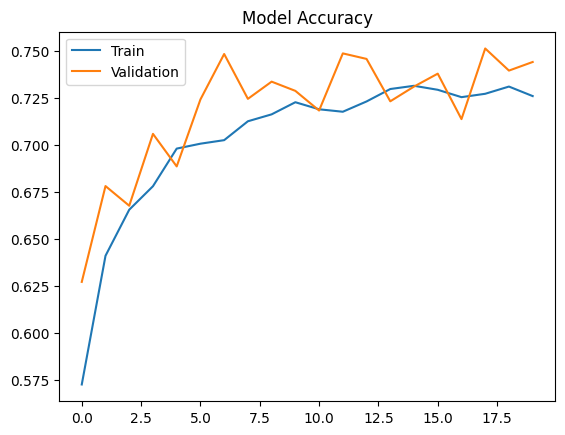

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

if 'X_prepared' in locals():
    # 1. Prepare Labels
    Y_cat = to_categorical(Y)

    # 2. Split Data
    x_train, x_val, y_train, y_val = train_test_split(
        X_prepared, Y_cat, test_size=0.2, random_state=42, stratify=Y_cat
    )

    print(f"Training Shape: {x_train.shape}") # Should be (N, 64, 192, 1)

    # 3. Calculate Class Weights
    y_integers = np.argmax(Y_cat, axis=1)
    class_weights_vals = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_integers),
        y=y_integers
    )
    class_weights = dict(enumerate(class_weights_vals))

    # 4. Compile
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    # 5. Train
    print("Starting training...")
    history = model.fit(
        x_train, y_train,
        batch_size=16,
        epochs=20,
        validation_data=(x_val, y_val),
        class_weight=class_weights,
        verbose=1
    )

    # 6. Plot
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.legend()
    plt.show()